In [18]:
import pandas as pd
import requests
from bs4 import BeautifulSoup

# Создание csv-таблицы с данными

Пройдемся по статьям с сайта [N+1](https://nplus1.ru/) за 2020 год, возьмем с их страниц заголовки, текст и тематику. Сформируем из них датафрейм. Именно его мы будет использовать для обучения нашей модели.

Работает довольно долго, так как код отрабатывает веб-скреппинг 2400 страниц.

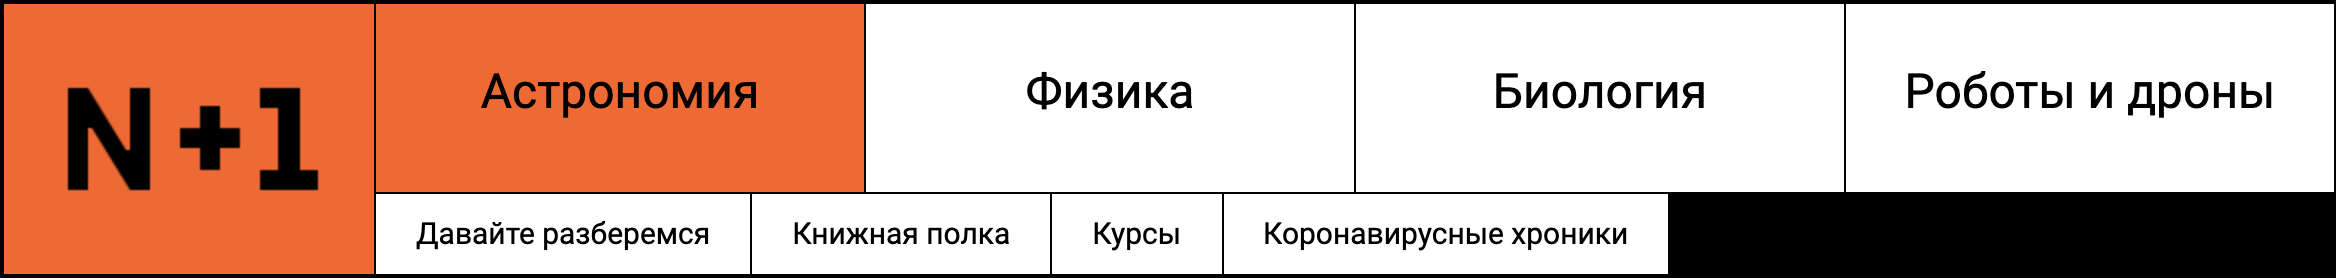

In [ ]:
main_address = 'https://nplus1.ru/'
month = '01'

title_column, article_text_column, classes_column, main_class_column = [], [], [], []

for month in [str(i).zfill(2) for i in range(1, 13)]:
    month_articles = requests.get(main_address + 'news/2020/' + month, params={'format': 'json'})
    page = BeautifulSoup(month_articles.text, 'html.parser')
    articles = page.findAll("article")

    for article in articles:
        link_article = article.a.get('href')

        article_page = requests.get(main_address + link_article, params={'format': 'json'})
        article_soup = BeautifulSoup(article_page.text, 'html.parser')

        title = article_soup.h1.text  # need

        body = article_soup.find("div", {"class": "body"})

        article_text_list = list()
        for p in body.findAll('p'):
            if not p.get('class'):
                article_text_list.append(p.text)

        article_text = ' '.join(article_text_list)  # need

        table = article_soup.find("p", {"class": "table"})

        classes = [a.text for a in table.findAll('a')]
        if classes:
            main_class = classes.pop(0)
        else:
            main_class = ''

        print(title)

        title_column.append(title)
        article_text_column.append(article_text)
        classes_column.append(' '.join(classes))
        main_class_column.append(main_class)


d = {'Title': title_column, 'Text': article_text_column, 'AdClasses': classes_column,
     'Class': main_class_column}

data = pd.DataFrame(d)
data.to_csv('Articles N+1.csv')

# Работа с данными

Импорт необходимых библиотек

In [17]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import MultinomialNB

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.gaussian_process import GaussianProcessClassifier
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping

from sklearn.metrics import accuracy_score, confusion_matrix,classification_report

import nltk
import nltk as nlp
import string
import re

Вывод информации из датафрейма

In [2]:
data = pd.read_csv('Articles N+1.csv')

data.head(10)

Unnamed: 0                                              Title  \
0           0  Увлечение пространства-времени впервые измерил...   
1           1  Ученые объяснили принятие решений с помощью кв...   
2           2  В России зарегистрированы первые случаи заболе...   
3           3  Первые носители «Авангардов» прослужат дольше ...   
4           4  Мочегонное средство помогло при расстройстве а...   
5           5  Телескоп «Спитцер» навечно отправили в спящий ...   
6           6  Финны и латвийцы займутся совместной разработк...   
7           7  Новый метод сравнения геномов выявил ДНК неанд...   
8           8  Американцы испытают двигательную установку эле...   
9           9  Химики синтезировали ароматическое кольцо с 16...   

                                                Text               AdClasses  \
0  Астрономы обнаружили первую звездную систему, ...              Астрономия   
1    Ученые из Китая создали два самообучающихся ...       Физика Нейронауки   
2  В России зарегистрированы первые случаи заболе...  Коронавирусные хроники   
3  Корпорация «НПО машиностроения» занялась продл...                     NaN   
4   Мочегонный препарат буметанид снизил выраженн...     Медицина Нейронауки   
5  Космический инфракрасный телескоп «Спитцер» за...                     NaN   
6  Министерства обороны Латвии и Финляндии заключ...                     NaN   
7  Американские ученые предложили новый способ ср...                Генетика   
8  Американский стартап Wright Electric в 2021 го...                     NaN   
9  Британские ученые синтезировали рекордно больш...                     NaN   

          Class  
0        Физика  
1      Биология  
2      Медицина  
3        Оружие  
4    Психология  
5  Космонавтика  
6        Оружие  
7  Антропология  
8       Авиация  
9         Химия

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  2400 non-null   int64 
 1   Title       2400 non-null   object
 2   Text        2398 non-null   object
 3   AdClasses   1058 non-null   object
 4   Class       2393 non-null   object
dtypes: int64(1), object(4)
memory usage: 93.9+ KB


Модель мы будем обучать исключительно на тексте статей, так что избавимся от лишних колонок.

In [29]:
df = data.drop(['AdClasses', 'Unnamed: 0'], axis=1)

In [30]:
df.dropna(inplace=True)

Рассмотрим распределение по классам.

<AxesSubplot:xlabel='Count', ylabel='Class'>

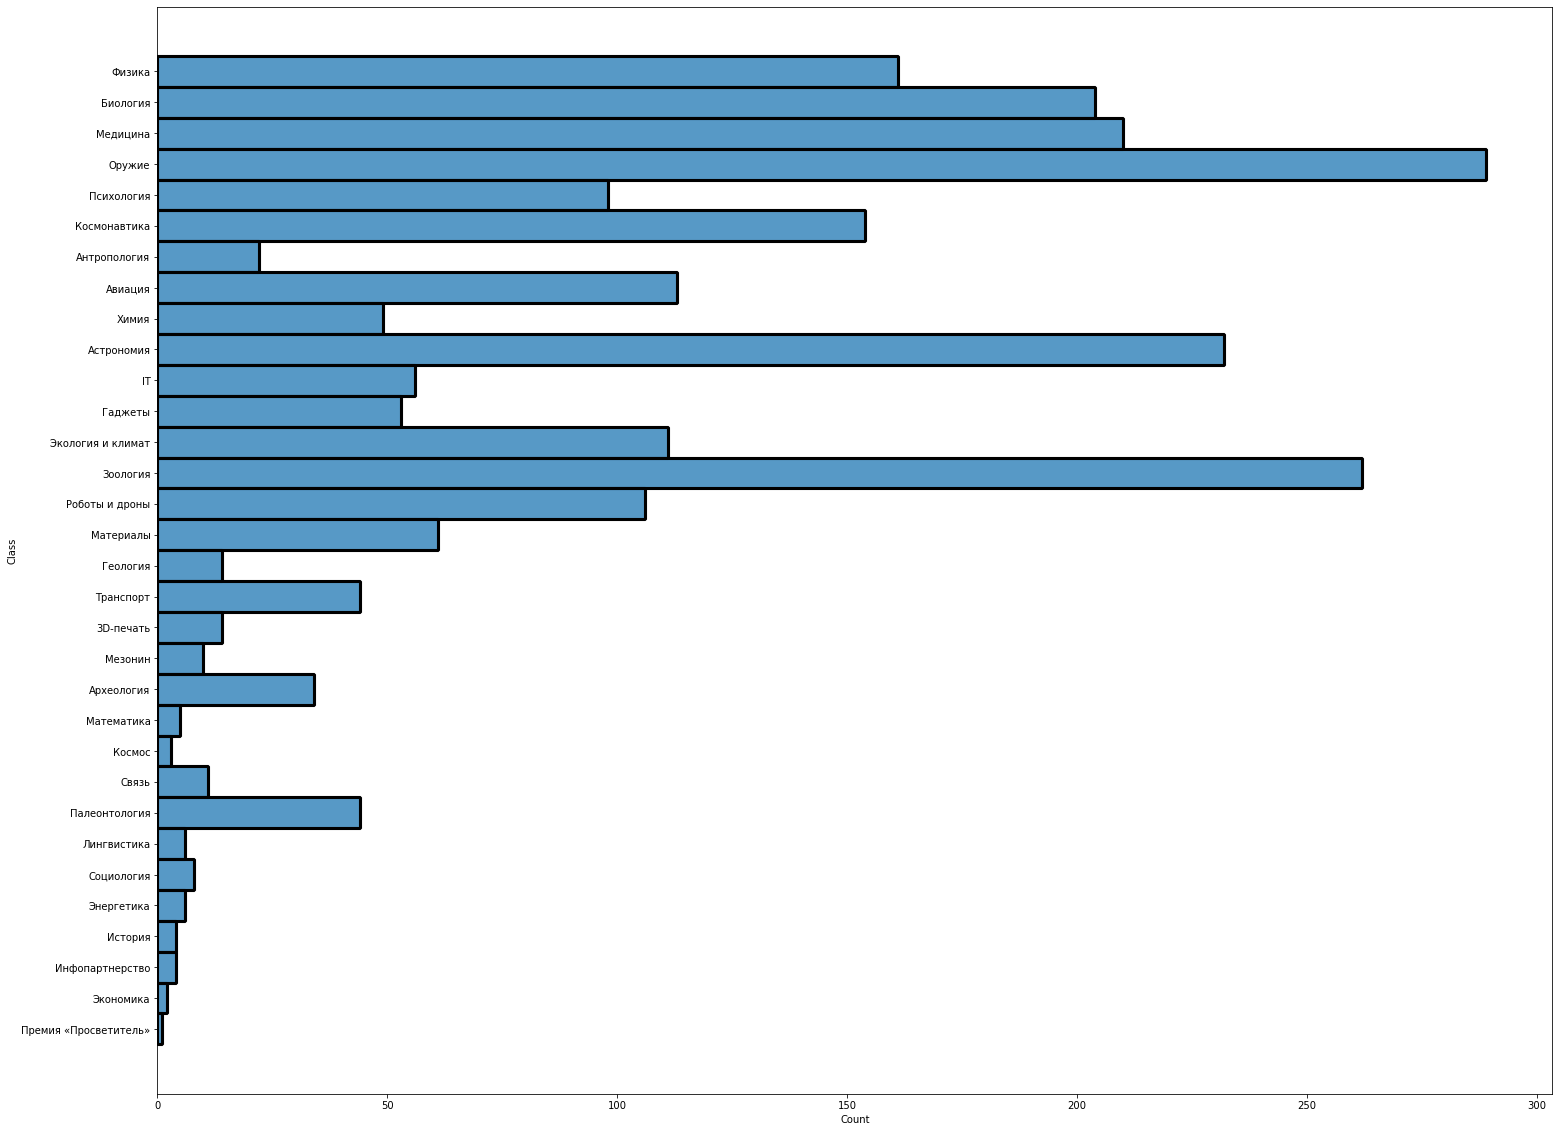

In [31]:
plt.figure(figsize=(25,20))
sns.histplot(df, y="Class")

Безусловно можно взять и обучиться по всем темам, но в таком случае точность предсказаний будет так себе (я проводил опыт, и на логической регрессии accuracy=62%)

Выделим три достаточно многочисленных класса, которые имеют примерно одинаковое количество представителей. Это статьи по зоологии, медицине и астрономии, например.

In [7]:
df = df[df['Class'] == 'Зоология'].append(df[df['Class'] == 'Медицина']).append(df[df['Class'] == 'Астрономия'])
df

Title  \
39    Альбатросы с датчиками засекли нелегальные рыб...   
64    Трупы оленей помогли членистоногим и растениям...   
110   Самой древней опухоли четвероногих оказалось б...   
127      Самцы шимпанзе подружились с братьями и отцами   
130                Волчата впервые принесли людям мячик   
...                                                 ...   
2322  Астрономы нашли на Нептуне «неправильное» темн...   
2330  Телескоп Кека уточнил расстояние до кандидата ...   
2355            Астрономы показали грунт астероида Рюгу   
2385             Астрономы нашли аналог Девятой планеты   
2390  Астрономы нашли солнечную радиовспышку у красн...   

                                                   Text       Class  
39    Европейские ученые использовали альбатросов дл...    Зоология  
64    Останки благородных оленей (Cervus elaphus) по...    Зоология  
110   Российские палеонтологи определили характер па...    Зоология  
127   Американские антропологи выяснили, что самцы ш...    Зоология  
130   Шведские зоологи неожиданно для себя обнаружил...    Зоология  
...                                                 ...         ...  
2322  Астрономы обнаружили, что крупное темное пятно...  Астрономия  
2330  Астрономы при помощи телескопа Кека уточнили р...  Астрономия  
2355  Контейнер, находившийся внутри возвращаемой ка...  Астрономия  
2385  Астрономы обнаружили экзопланету, котора совер...  Астрономия  
2390  Астрономы впервые продемонстрировали четкую вз...  Астрономия  

[704 rows x 3 columns]

Разобъем выборку на train и test

In [8]:
x_train, x_test, y_train, y_test = train_test_split(df['Text'].values, df['Class'], test_size=0.2, random_state=2021)

# Применение методов машинного обучения

Включим обработку текста в пайплайн, чтобы было удобнее и компактнее. Для обработки используются специальные методы из модуля `sklearn.feature_extraction.text`

## Logistic Regression Classifier

Задаем пайплайн

In [9]:
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

Обучаем модель и проверяем метрику accuracy

In [10]:
model = pipe.fit(x_train, y_train)
prediction = model.predict(x_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 97.87%


Метрики accuracy в данном случае всё же недостаточно, чтобы оценить, насколько хорошо наша модель определяет тематику статей, поэтому рассмотрим стандартные precision/recall/f1-score и support.

In [11]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

  Астрономия       1.00      0.98      0.99        49
    Зоология       0.96      0.98      0.97        50
    Медицина       0.98      0.98      0.98        42

    accuracy                           0.98       141
   macro avg       0.98      0.98      0.98       141
weighted avg       0.98      0.98      0.98       141



### Пример использования

Возьмем свежую статью с сайта по теме Астрономия. Проверим, сможет ли наша модель верно оценить тематику статьи.

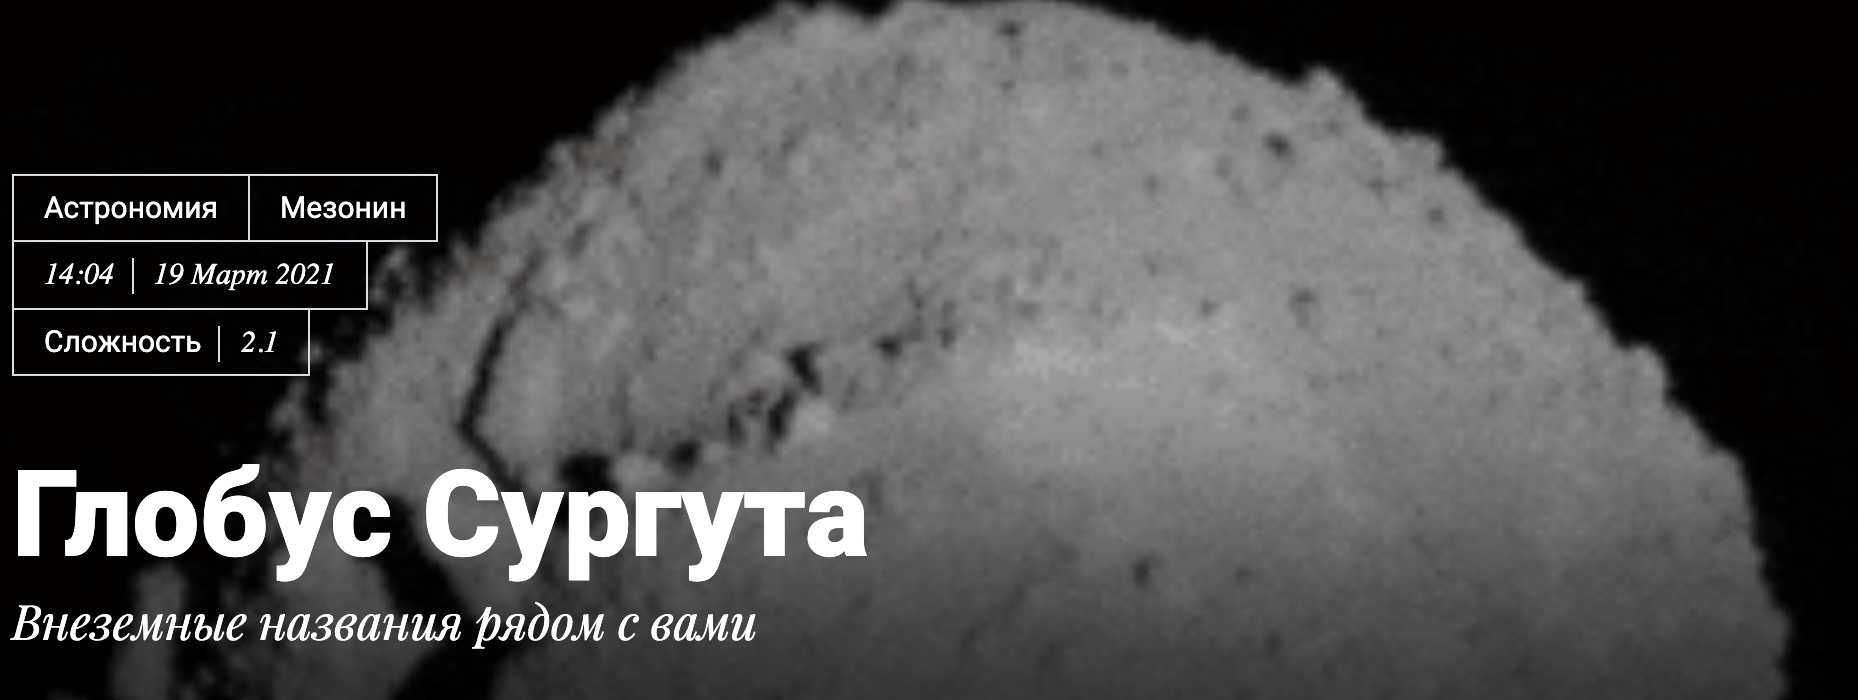

In [33]:
link = 'https://nplus1.ru/material/2021/03/19/surgut'
r = requests.get(link)
q = BeautifulSoup(r.text, 'html.parser')

body = q.find("div", {"class": "body"})
article_text_list = list()
for p in body.findAll('p'):
    if not p.get('class'):
        article_text_list.append(p.text)

article_text = ' '.join(article_text_list)
model.predict([article_text])

array(['Астрономия'], dtype=object)

Теперь возьмем свежую статью про птичек (Зоология)

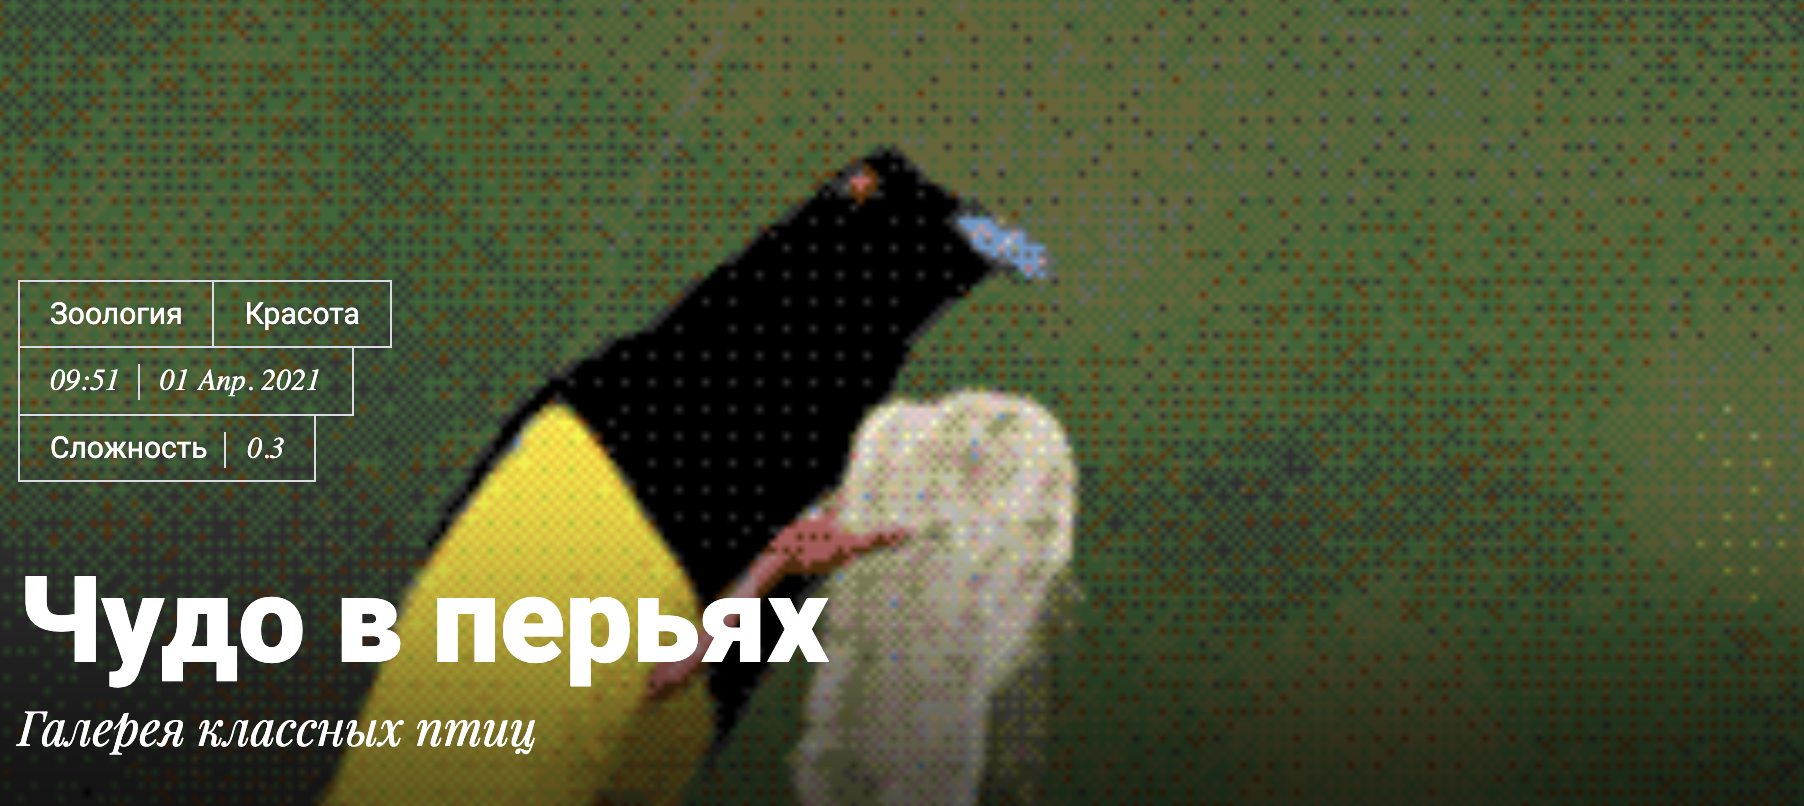

In [34]:
link = 'https://nplus1.ru/material/2021/04/01/birds'
r = requests.get(link)
q = BeautifulSoup(r.text, 'html.parser')

body = q.find("div", {"class": "body"})
article_text_list = list()
for p in body.findAll('p'):
    if not p.get('class'):
        article_text_list.append(p.text)

article_text = ' '.join(article_text_list)
model.predict([article_text])

array(['Зоология'], dtype=object)

На очереди медицинская статья

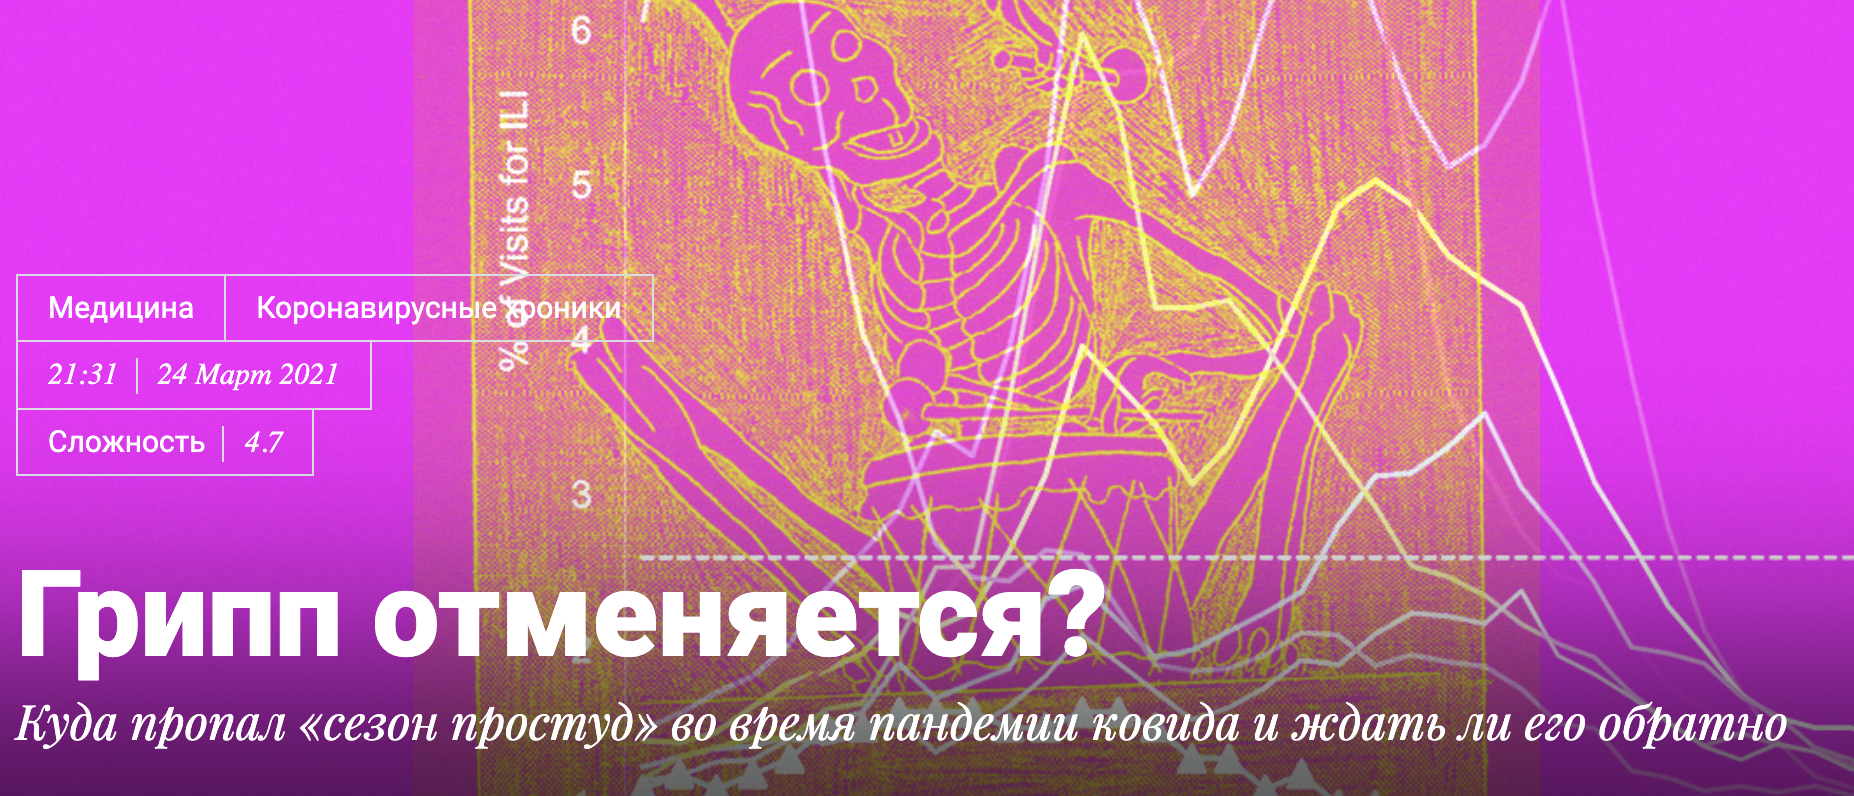

In [35]:
link = 'https://nplus1.ru/material/2021/03/24/covid-vs-flu'
r = requests.get(link)
q = BeautifulSoup(r.text, 'html.parser')

body = q.find("div", {"class": "body"})
article_text_list = list()
for p in body.findAll('p'):
    if not p.get('class'):
        article_text_list.append(p.text)

article_text = ' '.join(article_text_list)
model.predict([article_text])

array(['Медицина'], dtype=object)

## Вывод

Даже банальная логичстическая регрессия при должном парсинге и обработке текста позволяет хорошо классифицировать статьи.